## Import Modules and Prerequisites
---
Please use this section to import any necessary modules that will be required later in this notebook like the example given.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# add any needed libraries
import pickle
from pathlib import Path
from audio import *
from model import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping
%matplotlib inline

## Automatic Speech Recognition
---
#### Note: There is no expectation of coding a highly sophisticated solution in this current small time period. Each question can be answered either with a short code example along with a possible written explaination of a more elaborate approach or with not highly tuned models, due to lack of available resources and time.

A common task in Acoustics is to predict the speaker from corresponding audio signals (speaker identification). In the provided corpus (see the project description), you can find transcripts under various speech settings and speaking conditions. 

### 1. Train a classifier on the Solo Speech condition dataset that will reach an acceptable accuracy score.
---
Feel free to follow any design choices you feel fit the problem best. Briefly describe your approach in markdown cells, along with any necessary comments on your choices. Explain your choices with the appropriate evaluation plots - analysis

In [2]:
#Path initialization
ROOT_PATH = Path.cwd()
ROOT_DATASET_PATH = ROOT_PATH.joinpath('dataset')
SOLO_DATASET_PATH = ROOT_DATASET_PATH.joinpath('data').joinpath('solo')
TRAIN_FEATURES_EXPORT_PATH = ROOT_DATASET_PATH.joinpath('train_ftrs.pickle')
OUTPUT_PATH = ROOT_PATH.joinpath('output')

In [ ]:
#Create a list which contains all the audio files' paths in solo dataset
audiofiles = list((SOLO_DATASET_PATH).glob('**/*.wav'))

In [ ]:
SAMPLE_RATE = 16000 #Hz
SEGMENT_SIZE = 2000 #milliseconds
SEGMENT_OVERLAP = 2000 #milliseconds
NUM_MFCC = 13
N_FFT = 128 #milliseconds
HOP_LENGTH = 32 #milliseconds

feature_set = {
    "filename": [],
    "corpus": [],
    "user": [],
    "segment_id": [],
    "mfccs_conc": []
}

for file in audiofiles:
    try:
        filename = file.parts[-1]
        corpus = file.parts[-3]
        source = file.parts[-2]
        print(f'Processing file {filename} !!!')
        
        sig = audio_load(file, sr=SAMPLE_RATE)
        segs = split_to_signals(sig, sr=SAMPLE_RATE, size=SEGMENT_SIZE, slide=SEGMENT_OVERLAP)
        segment_id = 0
        for seg in segs:
            segment_id+=1
            mfccs_conc = extract_features(
                sig = seg,
                sr = SAMPLE_RATE,
                num_mfcc=NUM_MFCC,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH
            )

            # store data for analysed track
            feature_set["corpus"].append(corpus)
            feature_set["filename"].append(filename)
            feature_set["user"].append(source)
            feature_set["segment_id"].append(segment_id)
            feature_set["mfccs_conc"].append(mfccs_conc.T.tolist())

    except Exception as e:
        msg = f'Raised the exception: {e} for file {filename}'+ ' Skipping...'
        print(msg)
        continue

In [ ]:
# Save features locally in pickle format
with open(TRAIN_FEATURES_EXPORT_PATH, 'wb') as f:
    pickle.dump(feature_set, f)

In [3]:
# Prepare dataset for give it as input to DNN

def prepare_dataset(X, y, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    """

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)


    return X_train, y_train, X_validation, y_validation, X_test, y_test

### Setting up the experiment

Data loaded successfully!
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-05 02:19:50.447502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-05 02:19:50.447651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 256)           303104    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 36)                2340      
                                                                 
Total params: 847,204
Trainable params: 847,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-01-05 02:19:50.782085: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 02:19:51.693825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 02:19:51.997154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 02:19:52.087101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/152 [..............................] - ETA: 4:05 - loss: 3.4802 - accuracy: 0.0000e+00

2023-01-05 02:19:52.221939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 02:19:52.342406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - ETA: 0s - loss: 3.5149 - accuracy: 0.0785

2023-01-05 02:19:55.275962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 02:19:55.389337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 02:19:55.428401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - 5s 22ms/step - loss: 3.5149 - accuracy: 0.0785 - val_loss: 3.3804 - val_accuracy: 0.1815
Epoch 2/100
152/152 [==============================] - 3s 20ms/step - loss: 3.0775 - accuracy: 0.1674 - val_loss: 2.6139 - val_accuracy: 0.3366
Epoch 3/100
152/152 [==============================] - 3s 18ms/step - loss: 2.4310 - accuracy: 0.3140 - val_loss: 1.9675 - val_accuracy: 0.5033
Epoch 4/100
152/152 [==============================] - 3s 19ms/step - loss: 2.0230 - accuracy: 0.4215 - val_loss: 1.5750 - val_accuracy: 0.5941
Epoch 5/100
152/152 [==============================] - 3s 18ms/step - loss: 1.6880 - accuracy: 0.5269 - val_loss: 1.3181 - val_accuracy: 0.6799
Epoch 6/100
152/152 [==============================] - 3s 18ms/step - loss: 1.3953 - accuracy: 0.6079 - val_loss: 1.0737 - val_accuracy: 0.7211
Epoch 7/100
152/152 [==============================] - 3s 18ms/step - loss: 1.1417 - accuracy: 0.6810 - val_loss: 0.9098 - val_accuracy: 0.7376
Epoc

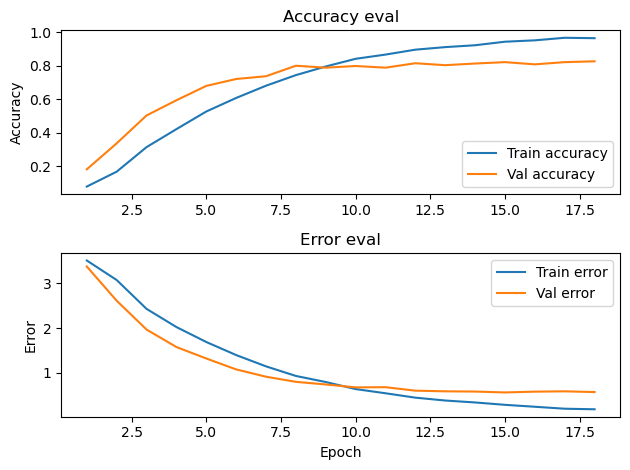

24/24 - 0s - loss: 0.5489 - accuracy: 0.8375 - 336ms/epoch - 14ms/step

Test accuracy: 0.8375165462493896


In [5]:
#Load the extracted feature set for the SOLO dataset
X, y = load_data(data_path = TRAIN_FEATURES_EXPORT_PATH)

#Label encoding
le = LabelEncoder()
y_enc = le.fit_transform(y)

#Split the dataset in train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(X, y_enc)

#Calculate the class weights (not totally necessary, the dataset is balanced in general)
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))

# Create the deep neural network
input_shape = (X_train.shape[1], X_train.shape[2]) # timesteps=16, features=39
n_classes = len(list(le.classes_))
model = build_model(input_shape, n_classes)

# Train model using earling stopping as we have a validation set
callback = EarlyStopping(monitor='val_loss', mode='min', patience=3)
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    batch_size=16, 
    epochs=100, 
    class_weight=class_weights,
    callbacks=[callback]
)

# plot accuracy/error for training and validation
plot_history(history, fullpath=OUTPUT_PATH.joinpath('train_history.jpg'))

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
scaler = StandardScaler()
X_ = scaler.fit_transform(X.reshape(-1, X.shape[-1]))
X__ = X_.

In [ ]:
scalers = {}
X___ = X.copy()
for i in range(X.shape[1]):
    scalers[i] = StandardScaler()
    X___[:, :, i] = scalers[i].fit_transform(X___[:, :, i]) 

In [ ]:
X[:, 0 , :].shape

### 2. Assuming that you needed to apply the learned rules / models on the Fast Speech condition dataset, without having that (test) dataset beforehand, what you would do?
---
The goal is to approach the classification accuracy obtained on the train dataset to the test dataset, without using the latter for training. Describe any challenges (if they exist) and code your solution below following the same guidelines 

### 3. Another important task is to perform gender classification on the same datasets, but there are no available labels. You can use the entirety of data you have at your disposal. Describe possible approaches to this problem and code the most robust solution of your choice. 

## Thank you in advance. Good luck!